In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt

In [2]:
idxmap=pd.read_csv("../input/spark_train_cleaned.csv",usecols=["Page"])['Page'].to_dict()

In [3]:
keys=pd.read_csv("../input/key_1.csv",index_col=0)
keys_dict=keys["Id"].to_dict()
len(keys_dict)

8703780

# make submission

In [4]:
pred=pd.read_csv("../input/spark_pred_mix2_xgb.csv",header=None)

In [5]:
date_cols=pd.date_range(pd.datetime.date(datetime.datetime(2017, 1, 1)), periods=60).map(lambda u: u.strftime("%Y-%m-%d")).tolist()
pred.columns=['ppage','Date','M']+date_cols

In [6]:
pred['pageidx']=pred.ppage.map(lambda u: int(u[1:]))

In [7]:
pred=pred.sort_values("pageidx")

In [8]:
for col in date_cols:
    pred[col]=np.exp(pred[col])*pred['M']

In [9]:
pred['page']=pred['pageidx'].map(lambda u: idxmap[u])

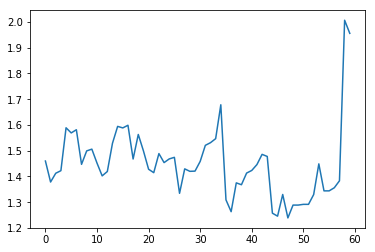

In [10]:
plt.plot(pred.loc[int(np.random.random()*pred.shape[0]),date_cols].values);

In [11]:
pred.index=pred['pageidx']

In [12]:
submission=pred.drop(['ppage','Date','M','pageidx','page'],axis=1)

In [13]:
submission=submission.unstack().reset_index()


In [14]:
submission['page']=submission['pageidx'].map(lambda u: idxmap[u])

In [15]:
submission['Id']=submission[['page','level_0']].apply(lambda u: "{}_{}".format(u.values[0],u.values[1]),axis=1)

In [16]:
submission=submission[['Id',0]]

In [17]:
submission["Id"]=submission["Id"].apply(lambda u:keys_dict[u])

In [18]:
submission.isnull().sum().sum()

0

In [19]:
newsubmission=submission
newsubmission.index=newsubmission['Id']
newsubmission=newsubmission.drop("Id",axis=1)

In [20]:
newsubmission.columns=['Visits']

In [21]:
(newsubmission.Visits<0.5).mean(),(newsubmission.Visits<0).mean()

(9.5245973588486835e-05, 0.0)

In [22]:
newsubmission.head()

Visits
Id                     
ff8c1aade3de  15.202225
3da6fd5b23c1  23.955156
cd9e83803be4   5.228469
65cd4af0968c  15.306222
75bae1fb2637  10.292485

In [23]:
newsubmission.to_csv("../submission/sub_pred_xgb_mix2.csv.gz",
                                    float_format='%.1f', compression="gzip")